In [16]:
from dask.distributed import Client, LocalCluster
client = Client("tcp://100.104.70.36:8786")

In [1]:
import numpy as np
import xarray as xr
import os
import glob
from pathlib import Path 
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import time
import requests
import s3fs
from os.path import dirname, join
import datetime
import myDate
import netCDF4
from scipy.optimize import least_squares
import time
import dask

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

In [2]:
alongtrack_file_dir = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/')
alongtrack_file_dir_randomnoise = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/')
alongtrack_file_dir_missingdata = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_missingdata_nosicapplied/')
alongtrack_file_dir_orbiterror_2cm = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/')
alongtrack_file_dir_3errors_2cm = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/')

beckley_dailyfile_dir = Path('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/')

main_dir = Path('/home/jpluser/ECCO_GMSL/')
output_dir = Path('/home/jpluser/ECCO_GMSL/Data/GMSL/')

data_dir = Path('/home/jpluser/ECCO_GMSL/Data/GMSL/')
ECCO_global_mean_sea_level_nosicapplied = xr.open_dataset(str(data_dir) + '/GMSL_ECCO_dailyfiles_19922017_nosicapplied.nc')

fig_dir = Path('/home/jpluser/ECCO_GMSL/Figures/')

# Parameters' weight

In [3]:
Vs = 7.2 #satellite along track velocity in km/s
Ve = 0.46 #velocity of earth's rotation at the equator in km/s
incidence = np.deg2rad(66.04) #satellite inclination
sig = 1 #uncertainty
alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(0)))
gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(0)) / (Vs*np.cos(alpha)) ))
beta0=np.pi/2 - gamma

In [4]:
start_date = np.datetime64('1950-01-01')
time_fiction=range(myDate.date2jj(1992,9,23),myDate.date2jj(2017,12,31)+11)

In [17]:
client

<Client: 'tcp://100.104.70.36:8786' processes=32 threads=32, memory=123.95 GiB>

In [103]:
def lat_convert_up(lat_down_values):
    # reverse 
    tmp = lat_down_values.astype('float32')/65535*180 - 90
    tmp[tmp==0] = np.nan
    return tmp

In [31]:
@dask.delayed
def gmsl_i(x,i):
    
        ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
        alongtrack = xr.open_mfdataset(
                paths=ECCO_alongtrack_files_cycle,
                combine='nested',
                concat_dim='i',
                decode_cf=True,
                compat='override',
                coords='minimal',
                chunks={'time': 1}  
            )
        
        alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
        SSH_at_xy_ano=alongtrack.SSH_at_xy.values
        alpha = np.arcsin(np.abs(np.cos(incidence)/np.cos(np.deg2rad(alongtrack.lat.values))))
        gamma = np.arctan(np.abs( (Vs*np.sin(alpha)-Ve*np.cos(np.deg2rad(alongtrack.lat.values))) / (Vs*np.cos(alpha)) ))
        beta = np.pi/2 - gamma
        
        # x_i is a vector of indices of x. One for each observation
        # values of x_i are [0..180], many duplicates because many observations 
        # have same integer latitude
        x_i = [ int(y+66) for y in alongtrack.lat.values ]

        if i == 0:
            print('unique x_i')
            print(np.unique(x_i))
            
        # x is the vector that we are solving for
        # it has one element for each integer latitude from 0..180 
        # sigma has the same number of elements as number of observations
        # each element has the value of x at the index x_i
        # where x_i relates to the latitutde
        # sigma = [x[x_i] for x_i in x_i]

        sigma = []
        for y_i in x_i:
            if y_i == 0:
                sigma_tmp = x[0]*0.5 + x[1]*0.5
            
            elif y_i == len(x)-1:
                sigma_tmp = x[y_i]*0.5 + x[y_i-1]*0.5
            
            else:
                #print(y_i, x[y_i], x[y_i-1], x[y_i+1])
                sigma_tmp = 0.25*x[y_i-1] + 0.5*x[y_i] + 0.25*x[y_i+1]
            
            sigma.append(sigma_tmp)
        
        # original weight
        w=np.sin(beta)/np.sin(beta0) #From Nerem 1995
        
        # modify each w by a sigma
        w = np.multiply(w, sigma)
        
        ind=np.where(np.isfinite(SSH_at_xy_ano))
        #time_gmsl = np.hstack((time_gmsl,time_fiction[i]))
    
        time_now = time_fiction[i]
        gmsl_now = np.nansum(SSH_at_xy_ano[ind]*w[ind])/np.nansum(w)

        output = {'time_now':time_now, 'gmsl_now':gmsl_now}

        return output


In [44]:
def this_is_fun(x):
    print(x)
    
    # cycles to process
    iis = np.arange(0,len(ECCO_alongtrack_files),50)
    #print(iis)
    
    results = []
    for i in iis:
        results.append(gmsl_i(x,i))
    zz = dask.compute(results)[0]

    # compile the gmsls into a single xarray object
    alongtrack_gmsl_tmp = []
    alongtrack_time_tmp = []
    
    for z in zz:
        alongtrack_gmsl_tmp.append(z['gmsl_now'])
        alongtrack_time_tmp.append(z['time_now'])
    
    alongtrack_gmsl_tmp= np.array(alongtrack_gmsl_tmp)
    alongtrack_time_tmp= np.array(alongtrack_time_tmp)
    alongtrack_gmsl = xr.DataArray(data=alongtrack_gmsl_tmp, dims=["time"], 
                                     coords=dict(time=start_date + np.timedelta64(1, 'D') * (alongtrack_time_tmp+4)),
                                     attrs=dict(summary="10-day GMSL time series computed on the alongtrack ECCO data", units="m"))
    alongtrack_gmsl.time.attrs['long_name'] = 'mid day of the 10-day average'
    alongtrack_gmsl.name = 'gmsl_ecco_alongtrack'
    
    # calculate residuals
    r = (alongtrack_gmsl-ECCO_global_mean_sea_level_nosicapplied.gmsl_ecco)   
    result = r.polyfit(dim = "time", skipna=True, deg = 1)
    trend = result.polyfit_coefficients.sel(degree=1).values*86400000000000*365
    mu=40000
    J = np.inner(r,r) + mu * trend**2

    # 30 digits of J
    print(f'J: {J:.30}')  

    return r
    # return np.sqrt(J)

In [8]:
ECCO_alongtrack_files = list(alongtrack_file_dir.glob('*ECCO_V4r4_alongtrack_SSH*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
# print(ECCO_alongtrack_files)

In [52]:
x=np.array([0.52830148, 0.32716331, 0.41363764, 0.46399488, 0.51079082,0.54178574,
 0.57341515, 0.61207627, 0.62819757, 0.59077296, 0.52872916, 0.4962608,
 0.49498194, 0.53193133, 0.60192898, 0.64327059, 0.63780988, 0.611433,
 0.59867644, 0.61919701, 0.66377597, 0.70797693, 0.73539957, 0.75436782,
 0.78068197, 0.785943  , 0.76324904, 0.73635243, 0.72099686, 0.71523617,
 0.72372774, 0.77318556, 0.85064906, 0.90524016, 0.92507213, 0.93381243,
 0.94302671, 0.94655065, 0.94431936, 0.94052436, 0.94051089, 0.94169705,
 0.93715479, 0.92257395, 0.90956491, 0.90510593, 0.90665454, 0.91603682,
 0.93106795, 0.93135025, 0.92542869, 0.93828402, 0.95535786, 0.96578689,
 0.9808594 , 0.99296525, 0.99436708, 0.98709183, 0.96399236, 0.938038,
 0.92529579, 0.92252899, 0.93322613, 0.96422696, 1.        , 1.,
 1.        , 1.        , 0.99896513, 0.99692184, 0.98907511, 0.98323896,
 0.9894585 , 0.9966246 , 0.99986184, 0.99669056, 0.96962312, 0.92558832,
 0.88912402, 0.88078504, 0.89681923, 0.9280283 , 0.95491584, 0.94826454,
 0.93602775, 0.92358481, 0.91479311, 0.91231511, 0.92021028, 0.9381218,
 0.9394654 , 0.92664703, 0.91110454, 0.9027643 , 0.89433377, 0.87895336,
 0.85807017, 0.8314019 , 0.81071636, 0.80666765, 0.80879994, 0.81460431,
 0.82418558, 0.80222092, 0.74981868, 0.73314466, 0.73896141, 0.7307471,
 0.73848102, 0.76292028, 0.76691262, 0.73671127, 0.68390264, 0.62766693,
 0.56826917, 0.5270504 , 0.51269279, 0.51157578, 0.5000651 , 0.51006939,
 0.57449006, 0.64256836, 0.67221631, 0.63232394, 0.57678129, 0.59623641,
 0.59311312, 0.52245001, 0.49695349, 0.51986424, 0.57882353, 0.71766577,
 0.9073143 ])
residuals=this_is_fun(x)

[0.52830148 0.32716331 0.41363764 0.46399488 0.51079082 0.54178574
 0.57341515 0.61207627 0.62819757 0.59077296 0.52872916 0.4962608
 0.49498194 0.53193133 0.60192898 0.64327059 0.63780988 0.611433
 0.59867644 0.61919701 0.66377597 0.70797693 0.73539957 0.75436782
 0.78068197 0.785943   0.76324904 0.73635243 0.72099686 0.71523617
 0.72372774 0.77318556 0.85064906 0.90524016 0.92507213 0.93381243
 0.94302671 0.94655065 0.94431936 0.94052436 0.94051089 0.94169705
 0.93715479 0.92257395 0.90956491 0.90510593 0.90665454 0.91603682
 0.93106795 0.93135025 0.92542869 0.93828402 0.95535786 0.96578689
 0.9808594  0.99296525 0.99436708 0.98709183 0.96399236 0.938038
 0.92529579 0.92252899 0.93322613 0.96422696 1.         1.
 1.         1.         0.99896513 0.99692184 0.98907511 0.98323896
 0.9894585  0.9966246  0.99986184 0.99669056 0.96962312 0.92558832
 0.88912402 0.88078504 0.89681923 0.9280283  0.95491584 0.94826454
 0.93602775 0.92358481 0.91479311 0.91231511 0.92021028 0.9381218
 0.939465

In [54]:
r=[-5.37593340e-04, -7.58174981e-04, -4.02133775e-04, -5.53855702e-04,
 -8.45017301e-04, -5.75205199e-04, -3.49624968e-04, -1.82920834e-04,
 -6.85373954e-04, -7.50464606e-04, -2.72233425e-04, -5.53323982e-04,
 -6.20344471e-04, -5.24876043e-04, -3.06976938e-04, -4.01754252e-04,
 -2.68225052e-04, -6.16154055e-04, -7.47405208e-04, -1.31313919e-04,
 -5.27711568e-04, -5.30725020e-04, -3.40074796e-04, -4.26877739e-04,
 -4.71205755e-04, -5.00870508e-04, -6.48203894e-04, -4.45737419e-04,
 -2.74068665e-04, -5.56761456e-04, -1.14159908e-03, -3.66284756e-04,
 -4.83647477e-04, -2.48542609e-04, -3.93571065e-04, -1.58236380e-04,
 -2.48313524e-04, -2.31492987e-04, -7.59786605e-04, -3.41088699e-04,
 -5.52627953e-04, -6.33697344e-04, -3.08414426e-04, -2.71994740e-04,
 -4.90555508e-04, -5.85725837e-04, -7.06253871e-04, -4.28649259e-04,
 -5.70107689e-04, -5.74245429e-04, -4.11316781e-04, -2.54308364e-04,
 -6.80127823e-04, -9.12494029e-04, -4.53893677e-04, -5.19979980e-04,
 -2.54909861e-04, -5.83009664e-04, -3.82769410e-04, -7.36052454e-04,
 -5.63898418e-04, -3.83552123e-04, -3.67552566e-04, -5.45999977e-04,
 -3.59833009e-04, -1.53522411e-04, -6.56270344e-04, -4.42366693e-04,
 -3.69650832e-04, -4.61357653e-04, -8.52645149e-04, -6.76008777e-04,
 -3.92186241e-04, -1.83262829e-04, -4.55364806e-04, -4.59237421e-04,
 -2.95716258e-04, -2.45002881e-04, -3.74437568e-04, -1.98021086e-04,
 -1.88101128e-04, -6.14906795e-04, -7.39464331e-04, -2.87873186e-04,
 -6.14101047e-04, -5.67973525e-04, -5.49107069e-04, -4.00679011e-04,
 -5.62382952e-04, -5.69022968e-04, -4.09560747e-04, -3.01810993e-04,
 -8.16008345e-04, -4.83761045e-04, -1.87035469e-04, -6.84332152e-04,
 -5.47619568e-04, -5.13004442e-04, -3.11236350e-04, -1.96177460e-04,
 -5.67391765e-04, -5.48386749e-04, -4.90800371e-04, -4.99678737e-04,
 -3.11055299e-04, -1.26405230e-04, -4.19556753e-04, -6.42594713e-04,
 -4.57972677e-04, -6.04870110e-05, -2.62284209e-04, -5.04144024e-04,
 -5.45553723e-04, -6.09607656e-04, -2.88752009e-04, -6.61770710e-04,
 -4.07265195e-04, -6.53703505e-04, -5.56914284e-04, -5.76271129e-04,
 -9.76617822e-04, -4.78840708e-04, -4.26533898e-04, -5.54259866e-04,
 -4.68777613e-04, -4.37496318e-04, -3.91827559e-04, -3.35689826e-04,
 -6.41438924e-04, -5.06201368e-04, -4.41893548e-04, -5.06838883e-04,
 -6.10468013e-04, -6.84456860e-04, -4.94059035e-04, -3.84550442e-04,
 -3.09122917e-04, -9.39603946e-04, -3.04832953e-04, -3.68845999e-04,
 -2.69388649e-04, -4.55386835e-04, -5.44799397e-04, -6.39618327e-04,
 -6.12325416e-04, -3.26261033e-04, -7.12342241e-04, -2.93015034e-04,
 -4.26723993e-04, -2.41223014e-04, -5.91294482e-04, -6.58184314e-04,
 -6.24140879e-04, -7.69733519e-04, -5.49367722e-04, -6.21811582e-04,
 -3.90223425e-04, -1.06029265e-04, -4.81962675e-04, -3.75562684e-04,
 -3.99641448e-04, -7.05894588e-04, -5.58419614e-04, -4.62791863e-04,
 -3.62344107e-04, -8.82695009e-04, -3.99336100e-04, -1.97635970e-04,
 -5.38101260e-04, -7.31797273e-04, -4.13515234e-04, -6.09950205e-04,
 -1.76149716e-04, -8.35888226e-04, -4.72626598e-04, -5.37811749e-04,
 -5.28307331e-04, -2.97723416e-04, -4.25305051e-04, -5.71033357e-04,
 -8.55343418e-04, -5.74794217e-04, -2.88096718e-04, -3.24187445e-04,
 -2.96846560e-04]

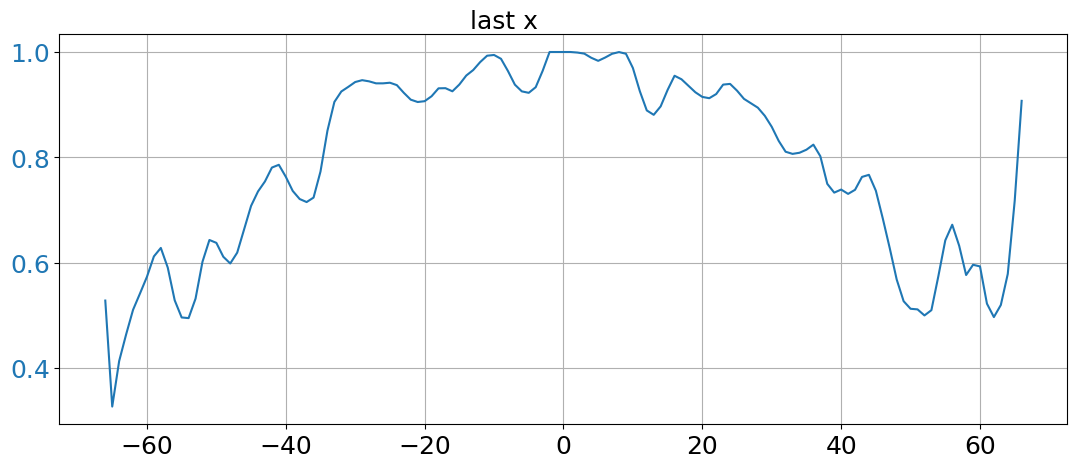

In [50]:
fig,ax=plt.subplots(figsize=(12,5))
ax.plot(np.arange(-66,67,1),x);
ax.grid()
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=18,labelcolor='#1f77b4')
fig.suptitle('last x', fontsize=18)
fig.subplots_adjust(left=0.13,top=0.93,bottom=0.15,right=0.97)

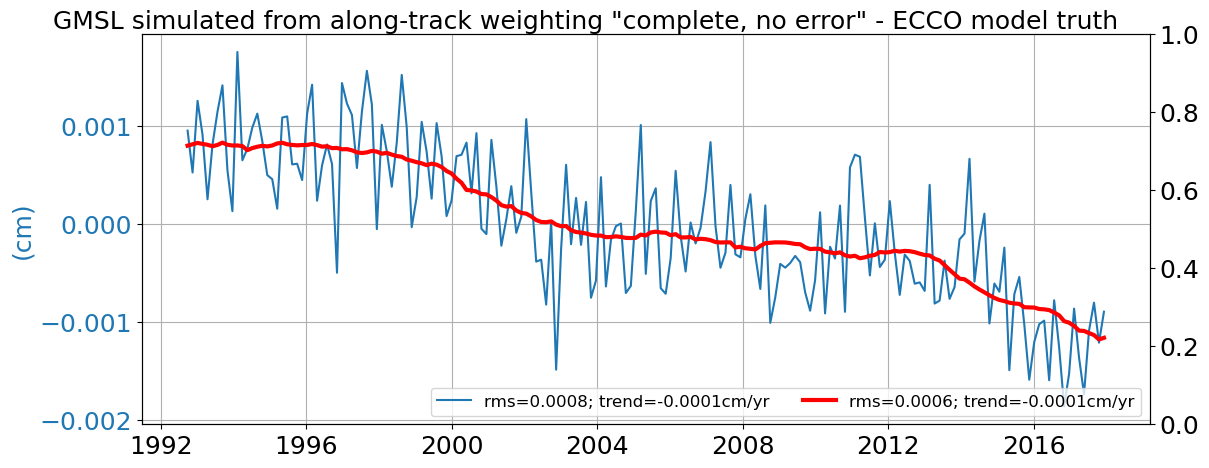

In [48]:
t=np.linspace(0, 1, len(residuals.time.values)) #need to be between 0 and 1
sig=xr.DataArray(data=residuals.values,dims=['time'],coords=dict(time=t))
smooth_diff_alongtrack=residuals.rolling(time=37, min_periods=1, center=True).mean()

ind = np.where(np.isfinite(sig.values))        
rms_alongtrack=np.sqrt(np.nansum(sig.values[ind]**2,axis=0)/len(ind[0]))
ind = np.where(np.isfinite(smooth_diff_alongtrack.values))        
smooth_rms_alongtrack=np.sqrt(np.nansum(smooth_diff_alongtrack.values[ind]**2,axis=0)/len(ind[0]))

result = residuals.polyfit(dim = "time", skipna=True, deg = 1)
trend = result.polyfit_coefficients.sel(degree=1).values*86400000000000*365
result = (smooth_diff_alongtrack).polyfit(dim = "time", skipna=True, deg = 1)
trend_smooth = result.polyfit_coefficients.sel(degree=1).values*86400000000000*365

fig,ax=plt.subplots(figsize=(12,5))
ax2 = ax.twinx()
ax.plot(residuals.time,residuals,label='rms='+"%.4f" % rms_alongtrack+'; trend='+"%.4f" % trend+'cm/yr');
ax.plot(smooth_diff_alongtrack.time,smooth_diff_alongtrack,linewidth=3,color='r',label='rms='+"%.4f" % smooth_rms_alongtrack+'; trend='+"%.4f" % trend_smooth+'cm/yr');
ax.grid()
ax.set_ylabel('(cm)',fontsize=18,color='#1f77b4')
ax.set_xlabel('')
ax2.set_xlabel('')
# ax.set_ylim(-0.35,0.35)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=18,labelcolor='#1f77b4')
ax2.tick_params(axis='both', which='major', labelsize=18,labelcolor='k')
fig.suptitle('GMSL simulated from along-track weighting "complete, no error" - ECCO model truth', fontsize=18)
ax.legend(ncol=2, loc='lower right',fontsize=12)
fig.subplots_adjust(left=0.13,top=0.93,bottom=0.15,right=0.97)

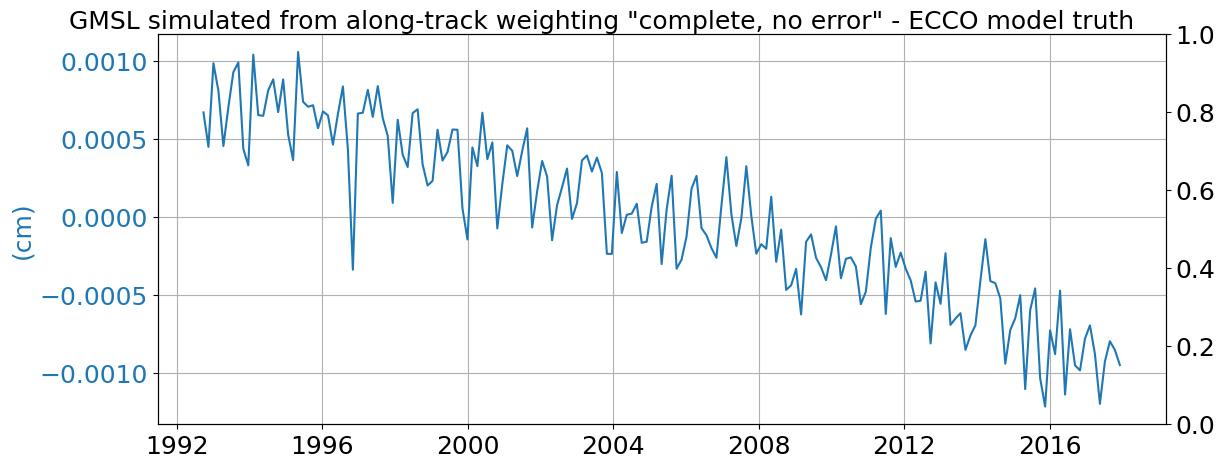

In [53]:
fig,ax=plt.subplots(figsize=(12,5))
ax2 = ax.twinx()
ax.plot(residuals.time,residuals);
# ax.plot(smooth_diff_alongtrack.time,smooth_diff_alongtrack,linewidth=3,color='r',label='rms='+"%.4f" % smooth_rms_alongtrack+'; trend='+"%.4f" % trend_smooth+'cm/yr');
ax.grid()
ax.set_ylabel('(cm)',fontsize=18,color='#1f77b4')
ax.set_xlabel('')
ax2.set_xlabel('')
# ax.set_ylim(-0.35,0.35)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=18,labelcolor='#1f77b4')
ax2.tick_params(axis='both', which='major', labelsize=18,labelcolor='k')
fig.suptitle('GMSL simulated from along-track weighting "complete, no error" - ECCO model truth', fontsize=18)
# ax.legend(ncol=2, loc='lower right',fontsize=12)
fig.subplots_adjust(left=0.13,top=0.93,bottom=0.15,right=0.97)

In [ ]:
# x=np.ones(len(range(0,133)))
# result=least_squares(this_is_fun, x, method='lm', loss='linear', verbose=1)
# result

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

in zz loop
mean r 5.375078711563724e-06 std r 0.0015764807976092975
J: 0.000459784310389870355499641885189
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

in zz loop
mean r 5.375078711563724e-06 std r 0.0015764807976092975
J: 0.000459